In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as sps

# Assignment 7 Q2 - Kamryn Parker and Patrick Chadbourne
Is there a positive correlation between if a movie has been nominated for an academy award and its ratings? Further more, is there a significant difference in mean ratings from nominated movies to non-nominated movies?

## Explanation of Question
For our second research question we wanted to learn more about award winning movies. Societally a movie that is nominated for an Academy Award is seen as the pinnacle of cinema. So does that actually hold true when looking at the data? Or are there still perfectly good movies that were enjoyed by users that were not nominated for an Oscar? To explore this question we decided to look at movies that were at least nominated in one category for an Academy Award. It did not matter what that category was and it didn't matter if it actually won for this exploration. We decided to keep it open becasue that way we had a little bit more data to work with. Since there are only a select few movies that win each year ther would not be much to work with when looking at the data.

Our further exploration will be testing a hypothesis to see if there is a significant difference in ratings between the two types of movies (nominated or not nominated). We will perform a two sample t-test on the data set to see if it yields any interesting results.

One thing to note with our entire dataset is we are not accounting for ratings after the nominations were announced. This is becasue the nominations do come out around the same time every year however, sometimes the date changes from month to month or week to week. This would cause it to be pretty difficult to time box a specific time frame of when nominations were announced. Therfore we are not accounting for it in this analysis, but could in future iterations.

To gather this data we used the MovieLens 25 dataset joined with a wikidata query of oscar nominated movies. This will be explained in more detail down below.

## Loading the Data

First, lets load in the data and use the most critical for our analysis. This will be of course our MovieLens user ratings and then our wikidata.

First, our user ratings data is loaded in and then we only need to know the movieId and rating of each. We are not interested in the userId since we are just looking at the ratings by movie not by user. 

In [2]:
user_ratings = pd.read_csv('ml-25m/ratings.csv')
user_ratings = user_ratings[['movieId', 'rating']]

Next, we want to group by movie ID and get the mean rating of the movie. We chose to do the mean rating as we thought it would be a better explanation of the spread of the data. Then we have to reset the index so we can merge it with out wiki data later on.

In [3]:
user_ratings = user_ratings.groupby('movieId').mean()
user_ratings = user_ratings.reset_index()

In order to link our user ratings together with our wiki data we have to know the proper ID. That is why we are also going to be using the linking dataset from MovieLens to the wiki data set using the tmdb ids.

In [4]:
links = pd.read_csv('ml-25m/links.csv')
links = links[['movieId', 'tmdbId']]

Now we introduce our new dataset for this question using WikiData's Sparql Query service. This data is loaded in using our script so it is already nicely formatted for us to use for our notebook. This dataset returns the tmdb movie id, movie title, and what the movie was nominated for. It returns roughly 3,000 results.

In [5]:
oscars = pd.read_csv('oscars.csv').drop(columns=['Unnamed: 0'])
oscars['tmdb_movie_id'] = oscars['tmdb_movie_id'].astype(int)
oscars.head()

,tmdb_movie_id,movie_title,nominated_count
0,98,Gladiator,"Academy Award for Best Writing, Original Scree..."
1,1391,Y tu mamá también,"Academy Award for Best Writing, Original Scree..."
2,629,The Usual Suspects,"Academy Award for Best Writing, Original Scree..."
3,12,Finding Nemo,"Academy Award for Best Writing, Original Scree..."
4,43234,Man of a Thousand Faces,"Academy Award for Best Writing, Original Scree..."


## Experimentation and Exploration
Now, we want to start combining our data and evaluate it to answer our questions.

First, lets condense down our oscar nominations list by grouping by movie id and title then getting the count of the number of nominations. This helps us not have duplicates and we can just focus on the singular movie title and that it holds a nomination.

In [6]:
oscars = oscars.groupby(['tmdb_movie_id','movie_title']).count()
oscars = oscars.reset_index()

Now let's combine this with our linking data to get the MovieLens ID number.

In [7]:
nominations = pd.merge(oscars, links, how='inner',left_on='tmdb_movie_id',right_on='tmdbId')
nominations  = nominations[['tmdb_movie_id','movieId','movie_title','nominated_count']]

Finally we have our nominated movies and their ratings merged below on the MovieLens movie ID. We also wanted to see quickly for fun which movies had the highest number of nominations in our data set. The answer is Titanic and interestingly enough it only has a pretty mid level mean rating and its considered one of the greatest movies of all time. Anyway, onto the correlation exploration!

In [8]:
nom_ratings = pd.merge(nominations, user_ratings, how='inner', on = 'movieId')
nom_ratings.sort_values(by = 'nominated_count', ascending = False)

,tmdb_movie_id,movieId,movie_title,nominated_count,rating
198,597,1721,Titanic,14,3.381152
466,1934,2396,Shakespeare in Love,13,3.790508
3101,313369,164909,La La Land,13,3.732564
125,396,2132,Who's Afraid of Virginia Woolf?,13,4.029346
44,120,4993,The Lord of the Rings: The Fellowship of the Ring,13,4.091189
...,...,...,...,...,...
1529,27017,8381,For Me and My Gal,1,3.617021
1528,26973,8499,Pretty Baby,1,3.467568
1527,26963,74553,The Secret of Kells,1,3.808303
1526,26941,1733,Afterglow,1,3.254491


Let's first look at the distribution of ratings per count of total nominations to see how it is distributed.

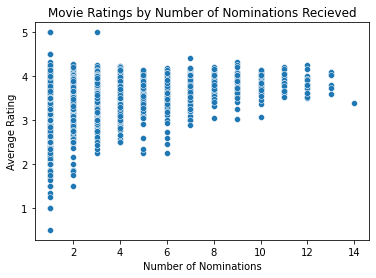

In [9]:
num_plot = sns.scatterplot(x = 'nominated_count', y = 'rating', data = nom_ratings)
num_plot = num_plot.set(title = 'Movie Ratings by Number of Nominations Recieved',
                      xlabel = 'Number of Nominations', ylabel = 'Average Rating')

We can see that there isn't neccesarily a linear relationship however, there is a slight increase as nomination numbers rise so do the mean ratings but not enough to be a linear relationship.

How does this fair when we see the correlation between the two? Let's look

In [10]:
nom_ratings['nominated_count'].corr(nom_ratings['rating'])

0.27292700479077436

As you can see the correlation is pretty low between these numbers. But that isn't neccesarily important considering this is not what we are trying to answer with our question. We looked at this just to see if there were any interesting patterns with the count of nominations per mean ratings. As we can see there is not much of a relationship. So, we can move on to our main analysis.

## Main Analysis
In order to analyze the relationships of ratings to nominated vs. not nominated we have to compare our nominated data set to our orignial user ratings data set. Doing this, we create a new column for 'nominations' in the user_ratings data set. We build this by checking if the user_ratings movieID matchs the nominated ratings movieID and if they do put a 1 and if not put a 0.

In [11]:
user_ratings['nominated'] = user_ratings.movieId.isin(nom_ratings.movieId).astype(np.int8)
user_ratings.head()

,movieId,rating,nominated
0,1,3.893708,1
1,2,3.251527,0
2,3,3.142028,0
3,4,2.853547,0
4,5,3.058434,0


Now let's look at the distribution of the two values in this column.

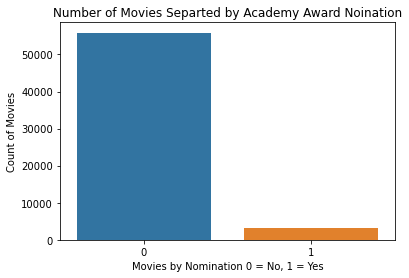

In [12]:
count_plot = sns.countplot('nominated', data = user_ratings)
count_plot = count_plot.set(title = 'Number of Movies Separted by Academy Award Noination',
                      xlabel = 'Movies by Nomination 0 = No, 1 = Yes', ylabel = 'Count of Movies')

As we can see there is a small data set of nominated movies comapred to non-nominated movies. That is okay and understandable since we are looking at about 25 million movies there won't be a lot that are nominated for an Academy Award. With this set we know that there would be a huge class imbalance so that is why we will not be trying to predict nomination status at this time. Instead we will just be looking at patterns and if there is a significant different in ratings. Lets look at the distribution of ratings per nomination status. 

To easily plot them I separeted the two into two separate dataframes similar to my before hand data processing but this will help us with our significance test later on.

In [13]:
nominated = user_ratings[user_ratings.nominated == 1]
non_nominated = user_ratings[user_ratings.nominated == 0]

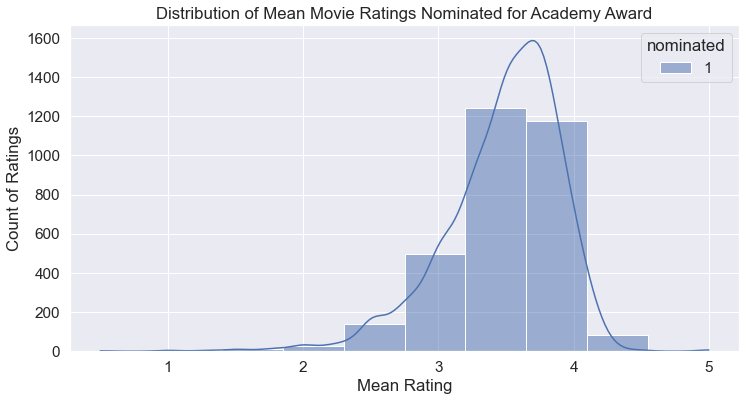

In [14]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale=1.4)
nom_plot = sns.histplot(data=nominated, x="rating", hue="nominated", kde = True, bins = 10)
nomPlot = nom_plot.set(title = 'Distribution of Mean Movie Ratings Nominated for Academy Award',
                      xlabel = 'Mean Rating', ylabel = 'Count of Ratings')

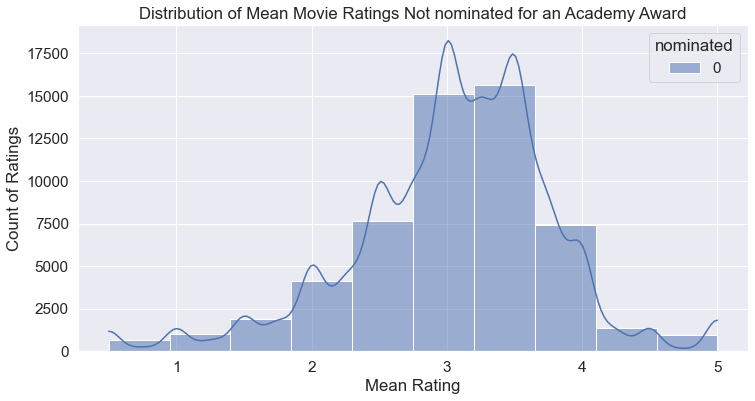

In [15]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale=1.4)
non_nom_plot = sns.histplot(data=non_nominated, x="rating", hue="nominated", kde = True, bins = 10)
non_nom_plot = non_nom_plot.set(title = 'Distribution of Mean Movie Ratings Not nominated for an Academy Award',
                      xlabel = 'Mean Rating', ylabel = 'Count of Ratings')

As you can see from the two plots, mean ratings for Academy Award nominated movies has a bit of a left skew towards hiring mean ratings. The non-nominated rating distribution has a larger spread and is a little bit more normally distributed. This is of course using a lower bin selection to show how each clumps together compared to one another.

Now, let's see if there is any correlation between a movie being nominated or not and their ratings.

In [16]:
user_ratings['nominated'].corr(user_ratings['rating'])

0.1312219419074496

It looks like there isn't neccesarily a strong correlation between these two vaules but that doesn't neccesarily rule out the significance of the nomination ratings versus the non-nominated ratings. So we will move on to our second part of our analysis. Is there a significant difference between the mean ratings of these statistics?

In [17]:
rng = np.random.default_rng(186527309)

To look at this we need to run an independent hyposthesis t-test where our null is that the sample mean is equal for the two categories and the alternative is they are not equal.

In [18]:
sps.ttest_ind(non_nominated['rating'], nominated['rating'], nan_policy='omit', equal_var=False)

Ttest_indResult(statistic=-52.1106102088906, pvalue=0.0)

We can see from our result that our p-value is small at 0.0 which is < the threshold of 0.05. This essentially points to that we can reject the null hypthesis in favor of their being some sort of a significant difference in mean rating of movies based on if they have an Academy Award nomination or not.

Finally, let us do a quick bootstrap sampling of the mean difference to see under conditions of resampling how the ratings differ.

In [19]:
def boot_ind(s1, s2, nboot=10000):
    ## we will ignore NAs here
    obs1 = s1.dropna()
    obs2 = s2.dropna()
    n1 = len(obs1)
    n2 = len(obs2)
    
    ## pool the observations together
    pool = pd.concat([obs1, obs2])
    ## grab the observed mean
    md = np.mean(s1) - np.mean(s2)
    
    ## compute our bootstrap samples of the mean under H0
    b1 = np.array([np.mean(rng.choice(pool, size=n1)) for i in range(nboot)])
    b2 = np.array([np.mean(rng.choice(pool, size=n2)) for i in range(nboot)])
    
    ## the P-value is the probability that we observe a difference as large
    ## as we did in the raw data, if the null hypothesis were true
    return md, np.mean(np.abs(b1 - b2) >= np.abs(md))

In [20]:
boot_ind(non_nominated['rating'], nominated['rating'])

(-0.42937825411157515, 0.0)

From here we can see that these ratings are different! At least the second value would be much larger if these two were too closely similar. 

## Reflection


Overall, this question was an interesting one to review and explore. Societally the Oscars are seen as the end all be all of awards cinema and so that is why I was so enamored with seeing if it was true in the actual ratings. One thing that has to be considered too is it is usually critics who determine what the best movie is each year and not neccesarily the audience members. That is why I think this was also interesting to explore on an audience level since they are not "experts" by any means but may listen to them to go see the movie. 

The struggle with this second question was where Patrick and I wanted to look at dempgraphics of a film cast as out initial question and see if that relates to movie score. However, data on that was extremely difficult to find, parse through, and present. So, we ended up going with a new question about Academy Awards which I think proved much more succesful in an exploratory analysis capacity. The reason why we did an exploration instead of a prediction was already touched on earlier in the project becasue we knew there would be such a large class imbalance. So, that is why instead we decided to look at patterns in sampling the distributions and seeing the differences. In the end I think we created a well rounded A7 research question project with interesting and eye opening questions.

In future revisions of this question it may prove useful to incorporate the Rotten Tomato Ratings for both users and critics to see if a critic's rating makes a significant difference or is correlated to a movie's success/ratings.